In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot accuracy and time cost
def plot_results(results):
    # Create a DataFrame from the results
    df = pd.DataFrame(results)

    # Plot 1: Accuracy across different datasets
    plt.figure(figsize=(12, 6))
    for model in df['model'].unique():
        subset = df[df['model'] == model]
        plt.plot(subset['dataset'], subset['accuracy'], marker='o', label=model)

        # Annotate each point with its accuracy value
        for i, row in subset.iterrows():
            plt.text(row['dataset'], row['accuracy'] + 1, f"{row['accuracy']:.2f}%", 
                     ha='center', va='bottom', fontsize=12, color='green')  # Accuracy annotation

    # Adding titles and labels for accuracy plot
    plt.title('Accuracy across Different Datasets\n\n')
    plt.xlabel('Datasets')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 110)  # Set y-axis limits to 0 - 100
    plt.legend(title='Model')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot 2: Time cost (Training and Testing time)
    plt.figure(figsize=(12, 6))

    # Bar plot for training time
    plt.subplot(1, 2, 1)
    for model in df['model'].unique():
        subset = df[df['model'] == model]
        plt.bar(subset['dataset'], subset['train_time'], label=model, alpha=0.7, color='yellow')

    # Adding titles and labels for training time
    plt.title('Training Time across Different Datasets')
    plt.xlabel('Datasets')
    plt.ylabel('Training Time (seconds)')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.grid()

    # Bar plot for testing time
    plt.subplot(1, 2, 2)
    for model in df['model'].unique():
        subset = df[df['model'] == model]
        plt.bar(subset['dataset'], subset['test_time'], label=model, alpha=0.7, color='green')

    # Adding titles and labels for testing time
    plt.title('Testing Time across Different Datasets')
    plt.xlabel('Datasets')
    plt.ylabel('Testing Time (seconds)')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.grid()

    # Adjust layout for the time plots
    plt.tight_layout()
    plt.show()

# Example of how to call the function after storing results
# plot_results(results)


In [2]:
# DATASETS
datasets = [
    # 'C:/Users/Natty PC/Documents/Party/Project II/PreData/Testing Data/5min-data.csv',
    # 'C:/Users/Natty PC/Documents/Party/Project II/PreData/Testing Data/all-malicious-5-mins.csv',
    # 'C:/Users/Natty PC/Documents/Party/Project II/PreData/Signatures/signatures-5mins.csv',
    # 'C:/Users/Natty PC/Documents/Party/Project II/PreData/Signatures/signatures-15mins.csv',
    # 'C:/Users/Natty PC/Documents/Party/Project II/PreData/Signatures/signatures-30mins.csv',
    # 'C:/Users/Natty PC/Documents/Party/Project II/PreData/Signatures/signatures-1hour.csv',
    # 'C:/Users/Natty PC/Documents/Party/Project II/PreData/Signatures/signatures-2hours.csv',
    # 'C:/Users/Natty PC/Documents/Party/Project II/PreData/Signatures/signatures-4hours.csv',
    # 'C:/Users/Natty PC/Documents/Party/Project II/PreData/Signatures/signatures-8hours.csv'
    'C:/Users/Natty PC/Documents/Party/Project II/PreData/Testing Data/all-mixed-5-mins.csv'
]

In [3]:
# DATA Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt

# Function to extract signature and frequency from a cell
def extract_signature_and_frequency(cell):
    if isinstance(cell, str):
        try:
            # Split by comma and remove brackets to extract signature and frequency
            signature, frequency = cell.replace('[', '').replace(']', '').split(',')
            return signature.strip(), int(frequency.strip())
        except ValueError:
            return None, 0  # In case of parsing failure, return None and 0 frequency
    return None, 0

# Function to load and preprocess dataset
def load_and_preprocess_data(dataset):
    # Load the dataset
    data = pd.read_csv(dataset)
    
    # Extract all columns that start with 'Fs'
    fs_columns = [col for col in data.columns if col.startswith('Fs')]
    
    # Create a set to collect unique signatures
    signature_set = set()
    for col in fs_columns:
        # Apply extraction function to each cell in the 'Fs' columns
        data[col] = data[col].apply(lambda cell: extract_signature_and_frequency(cell))
        # Update signature_set with signatures (ignore None)
        signature_set.update([sig for sig, _ in data[col] if sig])
    
    # Sort the unique signatures to create a consistent order for columns
    signature_list = sorted(list(signature_set))
    
    # Initialize the matrix with zeros as integers; rows = samples, columns = unique signatures
    X_matrix = np.zeros((data.shape[0], len(signature_list)), dtype=int)
    
    # Populate the matrix with frequencies
    for row_idx in range(data.shape[0]):
        for col in fs_columns:
            signature, frequency = data.at[row_idx, col]
            if signature in signature_list:
                sig_idx = signature_list.index(signature)  # Get the index for the signature
                X_matrix[row_idx, sig_idx] += frequency  # Update the corresponding cell with the frequency
    
    # Extract Y labels
    y = data['Label']
    
    # Encode Y labels into unique integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_encoded, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, signature_list, label_encoder




Dataset: C:/Users/Natty PC/Documents/Party/Project II/PreData/Testing Data/all-mixed-5-mins.csv
Initial Memory Usage: 223316.00 KiB
Accuracy: 96.59% 
Train Time: 0.4468s 
Test Time: 0.0070s
Memory Consumption During Training: 238124.00 KiB
Memory Consumption During Testing: 228040.00 KiB
Memory Usage Increase During Training: 14808.00 KiB
Memory Usage Increase During Testing: 4724.00 KiB
Model and signature list saved to Model - RF.joblib

Label classes (mapping):
{'Attack': 0, 'Benign': 1, 'C&C': 2, 'C&C-HeartBeat': 3, 'C&C-Torii': 4, 'DDoS': 5, 'Okiru': 6, 'PortScan': 7}


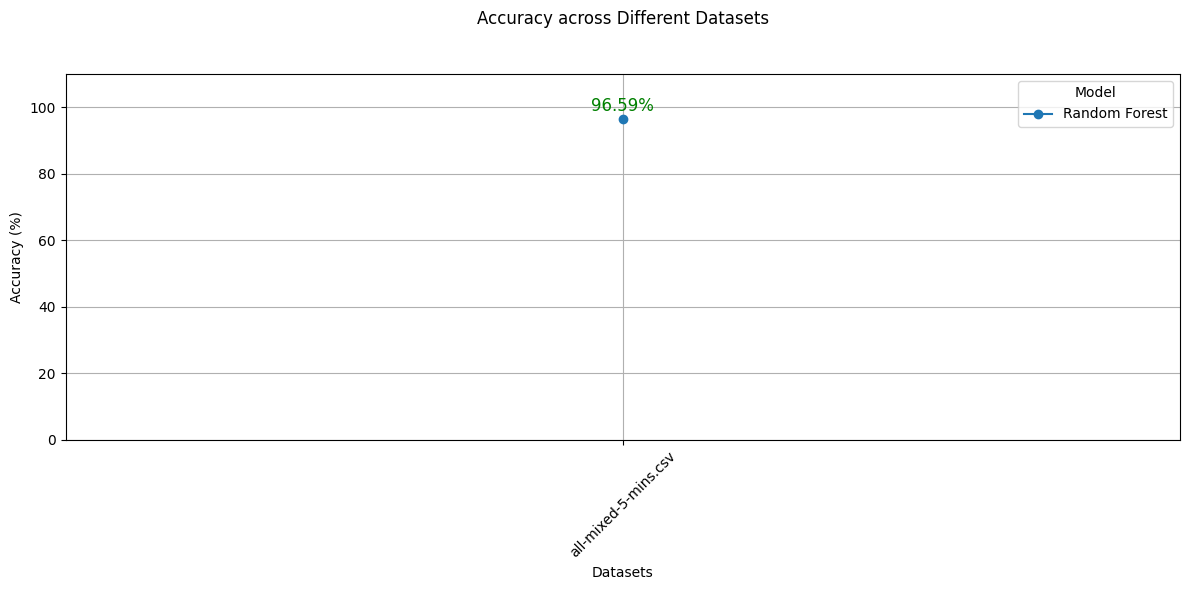

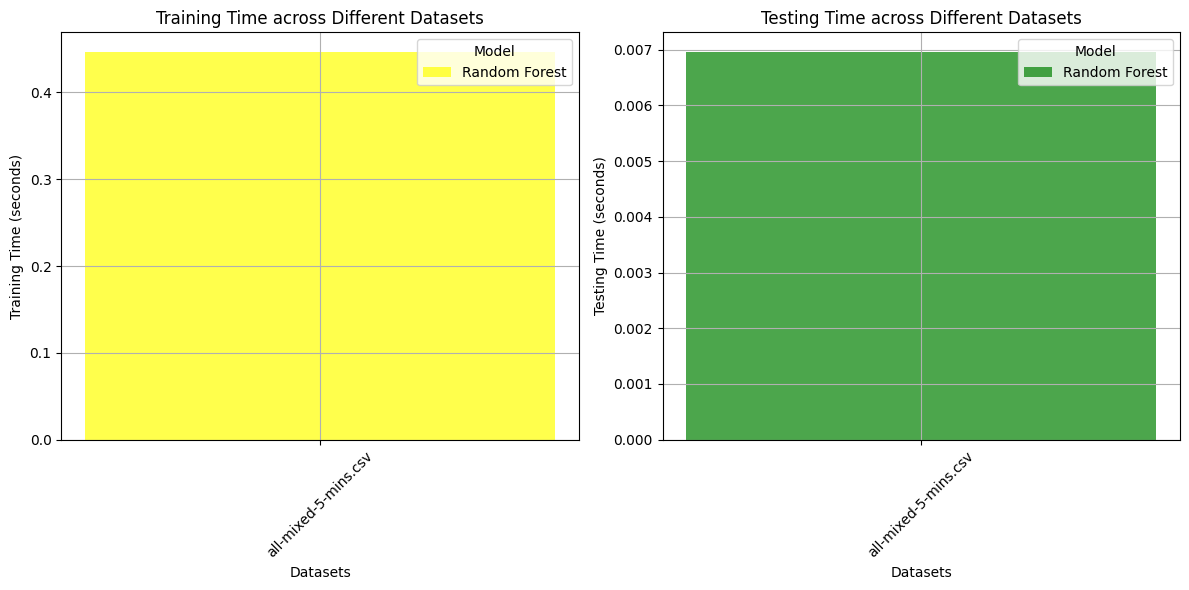

In [4]:
# Training and Test Model
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from memory_profiler import memory_usage
import joblib

results = []

# Iterate over the datasets
for dataset in datasets:
    print(f"\nDataset: {dataset}")

    # Load and preprocess the dataset
    X_train, X_test, y_train, y_test, signature_list, label_encoder = load_and_preprocess_data(dataset)

    # Scale the features (optional for Random Forest but may help with convergence)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Random Forest Model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    clf = rf_model
    

    # Measure initial memory usage
    initial_mem_usage_kib = memory_usage()[0] * 1024  # Convert to KiB
    print(f"Initial Memory Usage: {initial_mem_usage_kib:.2f} KiB")

    # Train the Random Forest model
    start_train_time = time.time()
    rf_model.fit(X_train_scaled, y_train)
    end_train_time = time.time()

    # Test the Random Forest model
    start_test_time = time.time()
    y_pred = rf_model.predict(X_test_scaled)  # Predict here
    end_test_time = time.time()

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}% \nTrain Time: {end_train_time - start_train_time:.4f}s \nTest Time: {end_test_time - start_test_time:.4f}s")

    # Show memory consumption
    max_mem_usage_train_kib = max(memory_usage((rf_model.fit, (X_train_scaled, y_train), {}), interval=0.1, timeout=1)) * 1024
    max_mem_usage_test_kib = max(memory_usage((rf_model.predict, (X_test_scaled,), {}), interval=0.1, timeout=1)) * 1024
    print(f"Memory Consumption During Training: {max_mem_usage_train_kib:.2f} KiB")
    print(f"Memory Consumption During Testing: {max_mem_usage_test_kib:.2f} KiB")

    # Calculate memory differences
    memory_diff_train = max_mem_usage_train_kib - initial_mem_usage_kib
    memory_diff_test = max_mem_usage_test_kib - initial_mem_usage_kib
    print(f"Memory Usage Increase During Training: {memory_diff_train:.2f} KiB")
    print(f"Memory Usage Increase During Testing: {memory_diff_test:.2f} KiB")

    # Save the trained model to a file with the name "Model - DCT"
    model_filename = "Model - RF.joblib"
    # model_filename = "Model - RF-mali.joblib"
    joblib.dump({'model': clf, 'signature_list': signature_list}, model_filename)
    print(f"Model and signature list saved to {model_filename}")

    print("\nLabel classes (mapping):")
    print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

    # Store results for plotting
    results.append({
        'dataset': dataset.split('/')[-1],  # Get just the dataset name
        'model': 'Random Forest',
        'accuracy': accuracy * 100,
        'train_time': end_train_time - start_train_time,
        'test_time': end_test_time - start_test_time
    })

# Optionally, plot results using the previously defined plot_accuracy function
plot_results(results)


In [5]:
# Print the results for validation
print("X_train matrix:")
print(X_train)
print("\nX_test matrix:")
print(X_test)
print("\ny_train labels (encoded):")
print(y_train)
print("\ny_test labels (encoded):")
print(y_test)
print("\nUnique signatures (features):")
print(signature_list)
print("\nLabel classes (mapping):")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

X_train matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

X_test matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

y_train labels (encoded):
[0 7 0 5 0 1 2 2 7 5 7 1 5 7 7 7 0 0 0 7 7 7 7 7 7 7 0 5 7 7 0 0 2 7 7 2 1
 7 1 7 2 7 1 0 7 7 0 7 7 2 7 7 7 2 7 1 7 0 7 7 7 7 2 7 7 7 7 2 7 7 7 7 7 0
 7 2 7 2 0 7 7 7 7 7 7 1 0 1 7 1 7 7 7 1 7 0 7 7 0 2 7 1 0 7 7 1 2 7 2 7 1
 7 7 7 7 2 0 2 7 4 0 0 7 2 0 7 7 7 7 7 7 7 2 1 1 7 7 2 2 2 7 7 2 7 7 7 7 7
 5 7 7 7 7 7 7 1 2 7 2 7 7 7 4 2 7 7 0 5 0 7 2 2 7 7 7 0 7 7 0 3 1 1 0 7 7
 0 1 0 7 7 7 5 0 2 7 7 0 7 7 2 5 2 7 2 7 2 7 7 0 7 0 2 0 7 2 7 2 7 7 0 0 7
 7 7 3 2 1 7 7 2 1 0 0 7 1 7 7 7 7 2 2 7 7 1 7 0 7 2 7 7 2 7 7 0 2 7 7 5 7
 7 7 1 0 5 7 5 7 7 2 7 0 2 2 0 2 7 7 2 0 2 7 1 2 0 0 2 7 7 0 7 7 7 0 2 7 0
 1 2 7 7 3 2 7 0 2 1 2 7 7 7 0 7 1 7 7 2 3 7 7 0 0 7 1 7 7 7 1 0 7 7 1 7 7
 0 0 7 0 2 2 7 7 7 7 0 2 6